<a href="https://colab.research.google.com/github/atick-faisal/MultiViewUNet-TAVI/blob/main/src/training/TAVI_CLF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report


# Fix GDrive

In [2]:
import shutil
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
shutil.copy("/content/drive/MyDrive/Research/TAVI/Dataset/TAVI_CLF_r17.zip", "TAVI_CLF_r17.zip")

'TAVI_CLF_r17.zip'

In [4]:
os.system('unzip -o "TAVI_CLF_r17.zip" > /dev/null')

0

# Downoad Data

In [5]:
# os.system('gdown "149lJdnX-iKbiv6vcWlcB4XqGkB5GshCC"')
# os.system('unzip -o "TAVI_STRESS_CLF_PARALLEL_v3.zip" > /dev/null')

# Load Data

In [6]:
DATA_DIR = "/content/Stress/"
train_X1 = np.load(DATA_DIR + "train_X1.npy")
train_X2 = np.load(DATA_DIR + "train_X2.npy")
train_X3 = np.load(DATA_DIR + "train_X3.npy")
train_X4 = np.load(DATA_DIR + "train_X4.npy")
train_X5 = np.load(DATA_DIR + "train_X5.npy")
train_X6 = np.load(DATA_DIR + "train_X6.npy")
train_Y = np.load(DATA_DIR + "train_y.npy")
test_X1 = np.load(DATA_DIR + "test_X1.npy")
test_X2 = np.load(DATA_DIR + "test_X2.npy")
test_X3 = np.load(DATA_DIR + "test_X3.npy")
test_X4 = np.load(DATA_DIR + "test_X4.npy")
test_X5 = np.load(DATA_DIR + "test_X5.npy")
test_X6 = np.load(DATA_DIR + "test_X6.npy")
test_Y = np.load(DATA_DIR + "test_y.npy")

# Config

In [7]:
IMG_SIZE = 160
BATCH_SIZE = 32
INITIAL_LEARNING_RATE = 3e-4
INITIAL_EPOCH = 300
EPOCH_PATIENCE = 30
FINE_TUNE_EPOCH = 0
TOTAL_EPOCH = INITIAL_EPOCH + FINE_TUNE_EPOCH

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Classification/Train/",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "Classification/Test/",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 432 files belonging to 2 classes.
Found 96 files belonging to 2 classes.


# Model Architecture

In [9]:
inputs = []
features = []

base_model = tf.keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

for i in range(1):
    inp = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.resnet.preprocess_input(inp)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    inputs.append(inp)
    features.append(x)

x = tf.keras.layers.concatenate(features)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [10]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE),
#     loss="binary_crossentropy",
#     metrics=["accuracy"]
# )

base_learning_rate = 0.0003
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name="accuracy")],
)

history = model.fit(
    # [train_X1],
    # train_Y,
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=INITIAL_EPOCH,
    # validation_data=([test_X1], test_Y),
    validation_data=test_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=EPOCH_PATIENCE,
            restore_best_weights=True
        )
    ]
)

Epoch 1/300
14/14 [==============================] - 14s 391ms/step - loss: 0.7487 - accuracy: 0.5833 - val_loss: 0.7071 - val_accuracy: 0.6250
Epoch 2/300
14/14 [==============================] - 4s 151ms/step - loss: 0.7567 - accuracy: 0.5903 - val_loss: 0.6409 - val_accuracy: 0.6250
Epoch 3/300
14/14 [==============================] - 3s 143ms/step - loss: 0.6934 - accuracy: 0.6181 - val_loss: 0.6498 - val_accuracy: 0.6042
Epoch 4/300
14/14 [==============================] - 4s 187ms/step - loss: 0.6865 - accuracy: 0.6250 - val_loss: 0.6390 - val_accuracy: 0.5938
Epoch 5/300
14/14 [==============================] - 4s 155ms/step - loss: 0.6849 - accuracy: 0.6319 - val_loss: 0.6355 - val_accuracy: 0.5938
Epoch 6/300
14/14 [==============================] - 3s 144ms/step - loss: 0.6457 - accuracy: 0.6458 - val_loss: 0.6420 - val_accuracy: 0.5938
Epoch 7/300
14/14 [==============================] - 3s 148ms/step - loss: 0.6891 - accuracy: 0.6204 - val_loss: 0.6373 - val_accuracy: 0.593

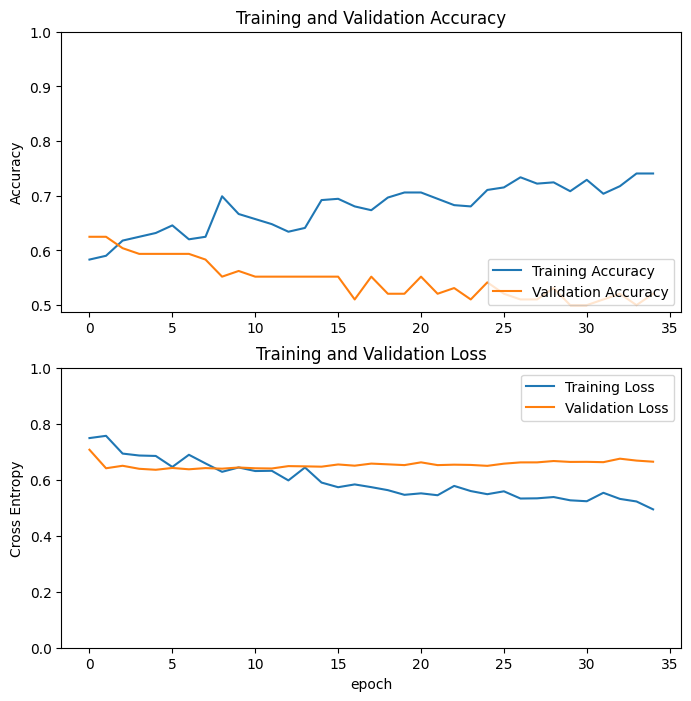

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [12]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(
    loss="binary_crossentropy",
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=INITIAL_LEARNING_RATE/10),
    metrics=["accuracy"]
)

history_fine = model.fit(
    [train_X1, train_X2, train_X3],
    train_Y,
    batch_size=BATCH_SIZE,
    epochs=TOTAL_EPOCH,
    initial_epoch=history.epoch[-1],
    validation_data=([test_X1, test_X2, test_X3], test_Y),
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor="val_loss",
    #         patience=EPOCH_PATIENCE,
    #         restore_best_weights=True
    #     )
    # ]
)

Number of layers in the base model:  175
Epoch 35/300


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 224, 224, 3) dtype=float32>]


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCH-1,INITIAL_EPOCH-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INITIAL_EPOCH-1,INITIAL_EPOCH-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation

In [ ]:
pred_y = model.predict([test_X1, test_X2, test_X3])
pred_y = np.round(pred_y).astype(int).reshape(-1)
test_y = test_Y.astype(int)

print(classification_report(test_y, pred_y))

cm = confusion_matrix(test_y, pred_y)
sns.heatmap(cm, annot=True, fmt="d")
